<a href="https://colab.research.google.com/github/srujan-b/facial-recogination-anti-spoofing/blob/main/facial_recogination_anti_spoofing_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

new_directory = '/content/drive/MyDrive/Face_Antispoofing/raw'
os.chdir(new_directory)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models

In [ ]:


class BasicBlockWithAttention(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockWithAttention, self).__init__()
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.shortcut = models.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut.add(layers.Conv2D(out_channels, kernel_size=1, strides=stride, use_bias=False))
            self.shortcut.add(layers.BatchNormalization())

    def call(self, inputs):
        x = layers.ReLU()(self.bn1(self.conv1(inputs)))
        x = self.bn2(self.conv2(x))
        x = layers.Add()([x, self.shortcut(inputs)])
        x = layers.ReLU()(x)
        return x

class ResNet18WithAttention(tf.keras.Model):
    def __init__(self, num_classes=1):
        super(ResNet18WithAttention, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()

        # Layer 1
        self.layer1 = models.Sequential([
            BasicBlockWithAttention(64, 64),
            BasicBlockWithAttention(64, 64)
        ])

        # Layer 2
        self.layer2 = models.Sequential([
            BasicBlockWithAttention(64, 128, stride=2),
            BasicBlockWithAttention(128, 128)
        ])

        # Layer 3
        self.layer3 = models.Sequential([
            BasicBlockWithAttention(128, 256, stride=2),
            BasicBlockWithAttention(256, 256)
        ])

        # Layer 4
        self.layer4 = models.Sequential([
            BasicBlockWithAttention(256, 512, stride=2),
            BasicBlockWithAttention(512, 512)
        ])

        # Global Average Pooling
        self.pool = layers.GlobalAveragePooling2D()

        # Fully Connected Layer
        self.fc = layers.Dense(num_classes)

    def call(self, inputs):
        x = layers.ReLU()(self.bn1(self.conv1(inputs)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.fc(x)
        return x

# Create the model
model = ResNet18WithAttention(num_classes=1)

# Print model summary
model.build(input_shape=(None, 224, 224, 3))  # Example input shape (batch_size, height, width, channels)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'res_net18_with_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "res_net18_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

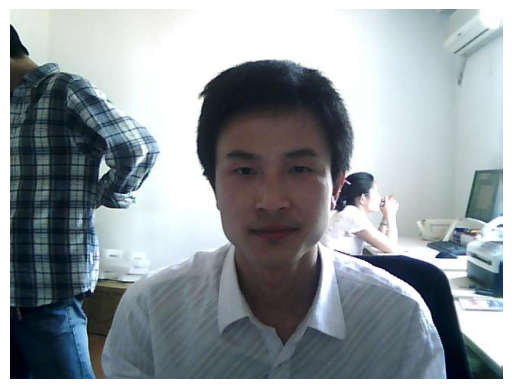

<class 'numpy.ndarray'>
(480, 640, 3)


In [ ]:
from PIL import Image
import numpy as np

# Load the image using Pillow
image_path = '/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_0.jpg'
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(image_array)
plt.axis('off')  # Hide axes
plt.show()

# The image is now a NumPy array
print(type(image_array))  # <class 'numpy.ndarray'>
print(image_array.shape)  # Shape of the image (height, width, channels)

In [35]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

class ASDatasetKeras:
    def __init__(self, client_file: str, imposter_file: str, preprocess=None):
        with open(client_file, "r") as f:
            client_files = f.read().splitlines()
        with open(imposter_file, "r") as f:
            imposter_files = f.read().splitlines()
        self.labels = np.concatenate((np.ones(len(client_files)), np.zeros(len(imposter_files))))
        self.imgs = client_files + imposter_files
        self.preprocess = preprocess

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img = Image.open("/content/drive/MyDrive/Face_Antispoofing/raw/"+img_name).convert("RGB")  # Ensure RGB format
        label = self.labels[idx]
        if self.preprocess:
            img = self.preprocess(img)
        else:
            img = np.array(img) / 255.0  # Normalize to [0, 1]
        return img, label

    def to_tf_dataset(self, batch_size=8, shuffle=False):
        def generator():
            for idx in range(len(self)):
                yield self.__getitem__(idx)

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),  # Image dimensions
                tf.TensorSpec(shape=(), dtype=tf.float32)               # Label
            )
        )
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(self.imgs))
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

# Define the preprocessing function
def preprocess(image):
    image = image.resize((224, 224))  # Resize to model's expected input size
    image = np.array(image) / 255.0  # Normalize
    return image

# Load datasets in Google Colab
client_train_path = "/content/drive/MyDrive/Face_Antispoofing/raw/client_train_raw.txt"
imposter_train_path = "/content/drive/MyDrive/Face_Antispoofing/raw/imposter_train_raw.txt"
client_val_path = "/content/drive/MyDrive/Face_Antispoofing/raw/client_test_raw.txt"
imposter_val_path = "/content/drive/MyDrive/Face_Antispoofing/raw/imposter_test_raw.txt"

# Prepare datasets
train_dataset = ASDatasetKeras(client_file=client_train_path, imposter_file=imposter_train_path, preprocess=preprocess)
val_dataset = ASDatasetKeras(client_file=client_val_path, imposter_file=imposter_val_path, preprocess=preprocess)

# Create TensorFlow data loaders
train_loader = train_dataset.to_tf_dataset(batch_size=2, shuffle=True)
val_loader = val_dataset.to_tf_dataset(batch_size=2, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Face_Antispoofing/raw/client_train_raw.txt'

In [ ]:
for images, labels in train_loader.take(1):  # Take the first batch
    print("Images shape:", images.shape)  # Prints the shape of the images in the batch
    print("Labels shape:", labels.shape)  # Prints the shape of the labels in the batch

    # Display the first image in the batch
    plt.imshow(images[0])  # Display the first image
    plt.title(f"Label: {labels[0].numpy()}")  # Display the label for the first image
    plt.axis("off")
    plt.show()

/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_0.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_101.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_105.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_109.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_112.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_116.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_12.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_123.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_127.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_130.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_134.jpg
/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001/0001_00_00_01_138.jpg
/content/drive/MyDr

In [ ]:
cd /content/drive/MyDrive/Face_Antispoofing/raw/0001/0001_00_00_01_0.jpg

[Errno 2] No such file or directory: '/content/drive/MyDrive/Face_Antispoofing/raw/0001/0001_00_00_01_0.jpg'
/content/drive/MyDrive/Face_Antispoofing/raw


In [ ]:
cd ..

/


In [ ]:
pwd

'/'

In [ ]:
ls

bin@                        dev/    lib64@                    opt/                run/   tools/
boot/                       etc/    libx32@                   proc/               sbin@  usr/
content/                    home/   media/                    python-apt/         srv/   var/
cuda-keyring_1.0-1_all.deb  lib@    mnt/                      python-apt.tar.xz*  sys/
datalab/                    lib32@  NGC-DL-CONTAINER-LICENSE  root/               tmp/


In [ ]:
cd /content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001

/content/drive/MyDrive/Face_Antispoofing/raw/ClientRaw/0001


In [ ]:
ls

ClientRaw/           client_train_raw.txt  imposter_test_raw.txt   readme.txt
client_test_raw.txt  ImposterRaw/          imposter_train_raw.txt
